In [24]:
import gurobipy as gb
import networkx as nx

import pygraphviz as pygv


import os
from IPython.display import SVG, display


#
# Drawing 
# functions
#

#
# Drawing 
# functions
#

def DrawInitialGraph():
    global DrawG
    DrawG = pygv.AGraph(directed='true',strict='true', splines='true')


    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i == root:
            DrawG.add_node (i, shape='circle', pos=pos, color="red", fontsize='8', width='0.3', fixedsize='true')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, color="black", fontsize='8', width='0.3', fixedsize='true')   	

    DrawG.layout(prog='neato', args='-n')
    DrawG.draw (path=str(basename) + '.svg', format='svg')
    DrawG.clear()


def DrawSol (x):

    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        DrawG.add_node (i, shape='circle', pos=pos,fontsize='8', width='0.3', fixedsize='true')

    DrawG.layout(prog='neato', args='-n')
    filepath=str(basename) + '_sol.svg'

    for i in G.edges():
        h = i[0]
        k = i[1]
        if x[i].x > 0.00001:
            lab = round(x[i].x,4)	
            if x[i].x > 0.999999:
                DrawG.add_edge(h, k, color='black', label=lab, fontsize='8')
            else:
                DrawG.add_edge(h, k, color='red', label=lab, fontsize='8')

    DrawG.draw (path=filepath, format='svg')
    DrawG.clear()

def DrawSubtour (x, subtour):
    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i in subtour:
            DrawG.add_node (i, shape='circle', pos=pos, fontsize='8', width='0.3', fixedsize='true', style='filled')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, fontsize='8', width='0.3', fixedsize='true')

    DrawG.layout(prog='neato', args='-n')
    filepath=str(basename) + '_sub.svg'

    for i in G.edges():
        h = i[0]
        k = i[1]
        if x[i].x > 0.00001:
            lab = round(x[i].x,4)	
            if x[i].x > 0.999999:
                DrawG.add_edge(h, k, color='black', label=lab, fontsize='8')
            else:
                DrawG.add_edge(h, k, color='red', label=lab, fontsize='8')

    DrawG.draw (path=filepath, format='svg')
    DrawG.clear()

    
class args:
    filename = None
    scale = 20

In [25]:
# 
# Read the graph in the graphML format
#


args.filename = 'atspexample.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())


G has 12 nodes and 132 edges
True


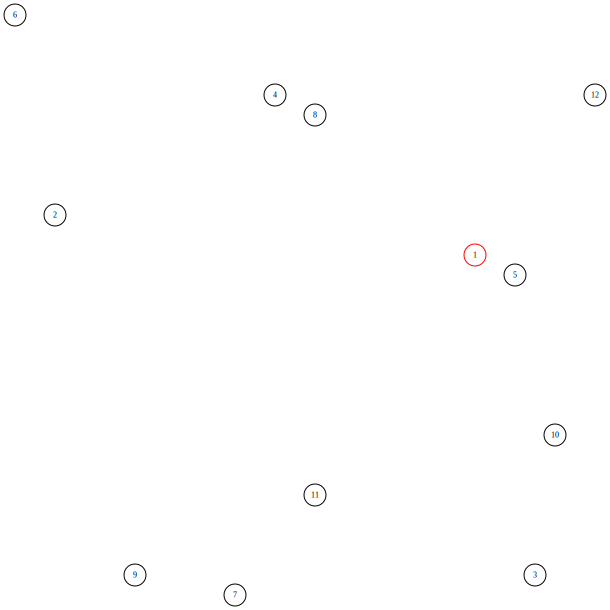

In [26]:
root = 1

DrawInitialGraph()

display(SVG(filename=basename+'.svg'))

## ATSP: compact formulation

Miller-Tucker-Zemlin formulation
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N \;\; \text{(RS)}\\
u_i - u_j + 1 & \le (n-1)(1-x_{ij}) \;\; \forall (i,j) \in A, i\not=1,j\not=1 \;\; \text{(MTZ)}\\
x & \in \{0,1\}^{|A|}\\
u_1 &= 1\\
2 &\le u_i \le n \;\; \forall i \in N, \not = \{1\}
\end{alignat}
$$

Miller-Tucker-Zemlin lifted formulation (Desrochers-Laporte)
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N \;\; \text{(RS)}\\
u_i - u_j + (n-1)x_{ij} + (n-3)x_{ji} &\le n-2 \;\; \forall (i,j) \in A, i\not=1,j\not=1 \;\; \text{(MTZ)}\\
x & \in \{0,1\}^{|A|}\\
u_1 &= 1\\
2 &\le u_i \le n \;\; \forall i \in N, \not = \{1\}
\end{alignat}
$$


In [27]:
atsp_mtz = gb.Model()

x = atsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

u = atsp_mtz.addVars(G.nodes(), obj=[0.0 for i in G.nodes()],\
                     lb=2.0, ub=G.number_of_nodes(), vtype=gb.GRB.CONTINUOUS,\
                    name='u')



In [28]:
atsp_mtz.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes()), name='FS')

atsp_mtz.update()


In [29]:
atsp_mtz.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes()), name='RS')

atsp_mtz.update()


## Lifted Miller-Tucker-Zemlin constraints

In [30]:
u[root].lb = 1.0
u[root].ub = 1.0

In [31]:
atsp_mtz.addConstrs((u[i] - u[j] + (G.number_of_nodes() - 1) * x[i,j] + \
                   (G.number_of_nodes() - 3) * x[j,i] <= (G.number_of_nodes() - 2)\
                   for i in G.nodes()\
                    for j in G.nodes()\
                   if (i != j) and (i != root) and (j !=root) \
                     and G.has_edge(i,j) and G.has_edge(j,i)), name='MTZ')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [32]:
atsp_mtz.optimize()

Optimize a model with 134 rows, 144 columns and 704 nonzeros
Variable types: 12 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 134 rows, 143 columns, 704 nonzeros
Variable types: 11 continuous, 132 integer (132 binary)
Found heuristic solution: objective 23327.000000
Found heuristic solution: objective 22467.000000

Root relaxation: objective 1.128245e+04, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 11282.4545    0   15 22467.0000 11282.4545  49.8%     -    0s
H    0     0                    19556.000000 11282.4545  42.3%     -    0s
H    0     0                    14733.000000 11282.4545  23.4%     -    0s
H    0     0    

In [33]:
DrawSol(x)


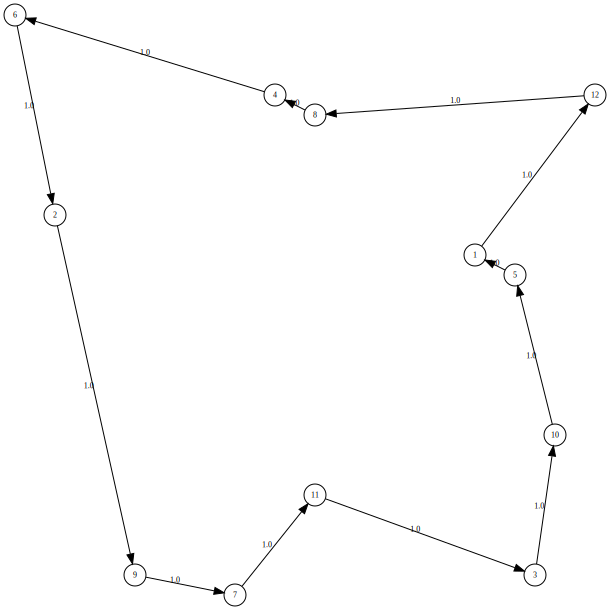

In [34]:
display(SVG(filename=basename+'_sol.svg'))